# Analysis Plan

1. Check normality in demographics
2. Transform value choices to cosine distance from expected assignments
3. Check bias in data: Any correlations between value choices and demographic data?
4. Determine power
5. Determine significance

In [19]:
import math
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kendalltau, linregress, iqr
from scipy.spatial.distance import cosine
from scipy.ndimage import rotate
import seaborn as sns

In [2]:
data_df = pd.read_csv('./data/study-responses.csv')
data_df.head()

,Timestamp,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,age,gender,education,reading,years_gaming,gaming_per_week,familiarity
0,6/18/2023 12:50:37,5,5,7,0,5,1,1,7,4,29,0,1,0,0,2,0
1,6/20/2023 14:12:29,5,5,7,8,4,1,1,3,4,25,1,2,1,0,2,0
2,6/20/2023 15:09:29,5,7,3,8,5,2,2,5,4,22,1,1,1,0,0,1
3,6/20/2023 22:46:46,4,5,7,8,4,2,2,3,4,28,0,3,1,0,0,0
4,6/21/2023 3:53:42,5,5,7,8,5,1,4,5,4,35,0,1,1,0,2,3


## Visualize demographics data

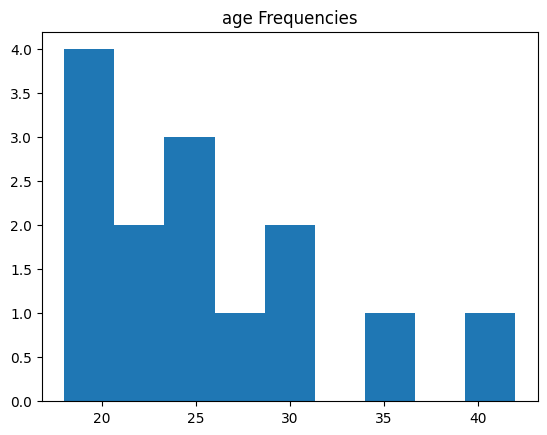

Shapiro-Wilks test: 0.09259679913520813


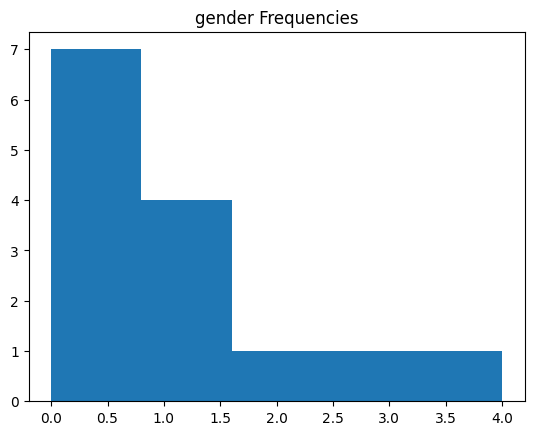

Shapiro-Wilks test: 0.0016729218186810613


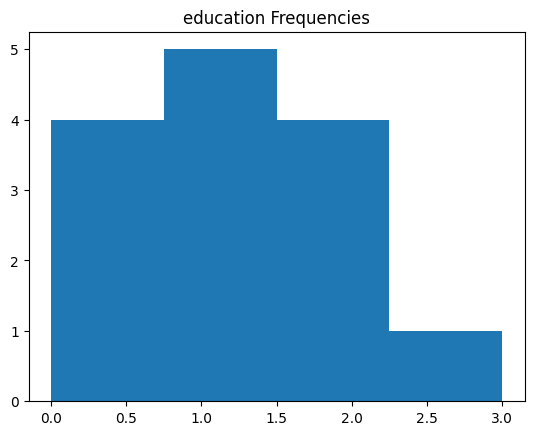

Shapiro-Wilks test: 0.06282538175582886


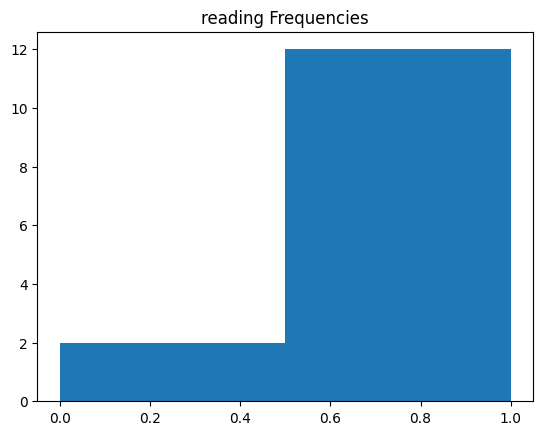

Shapiro-Wilks test: 1.7121129758379539e-06


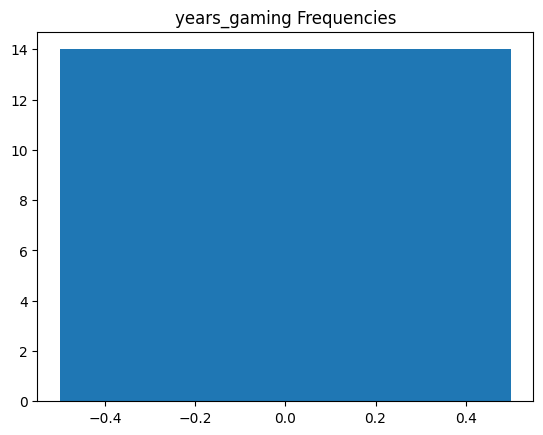

Shapiro-Wilks test: 1.0


/home/lag/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


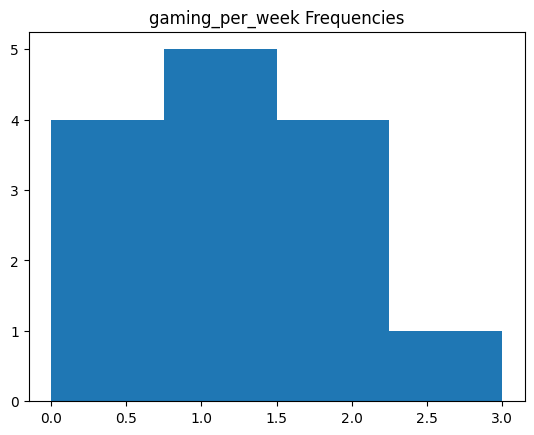

Shapiro-Wilks test: 0.06282538175582886


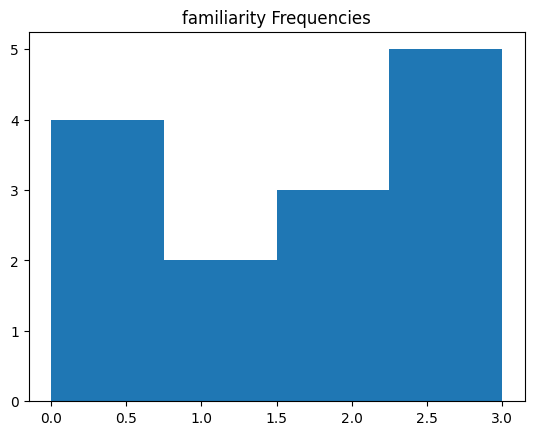

Shapiro-Wilks test: 0.008831472136080265


In [3]:
demo_columns = ['age', 'gender', 'education', 'reading', 'years_gaming', 'gaming_per_week', 'familiarity']
ticks = [[
    18,
    22,
    24,
    25,
    28,
    29,
    35,
], [
    'male', 'female', 'nonbinary', 'don\'t know', 'none'
], [
    'high school', 'bachelor degree', 'master degree', 'doctorate'
], [
    'somewhat confident', 'extremely confident'
], [
    '5+ years'
], [
   '0-5',
    '5-10',
    '10-20',
    '20+'
], [
    'somewhat unfamiliar', 'neither familiar nor unfamiliar', 'somewhat familiar', 'very familiar'
]]

for idx, col in enumerate(demo_columns):
    # get the column from the df
    column_s = data_df[col]
    if not column_s.dtype == 'int64':
        continue
    # visualize with histogram
    figure = plt.figure()
    counts, bins = np.histogram(column_s) 
    plt.hist(column_s, bins=len(set(column_s)), label=ticks[idx])
    
    plt.title(f'{col} Frequencies')
    plt.show()
    # shapiro wilk test for normality
    res = shapiro(column_s)
    print(f'Shapiro-Wilks test: {res.pvalue}')
    

In [4]:
### Same as above, but with value assignments

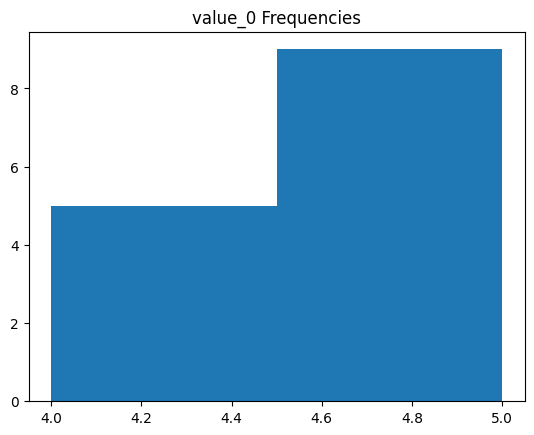

Shapiro-Wilks test: 5.650239472743124e-05


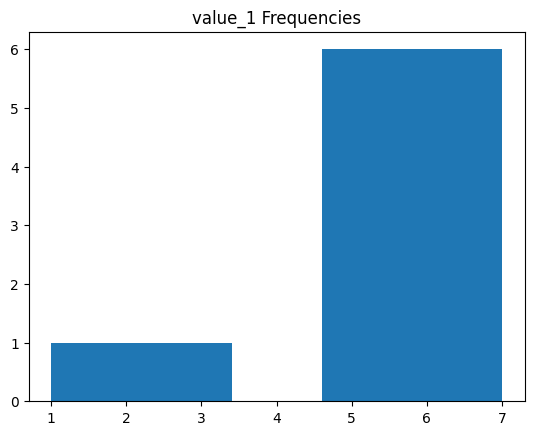

Shapiro-Wilks test: 0.01159956119954586


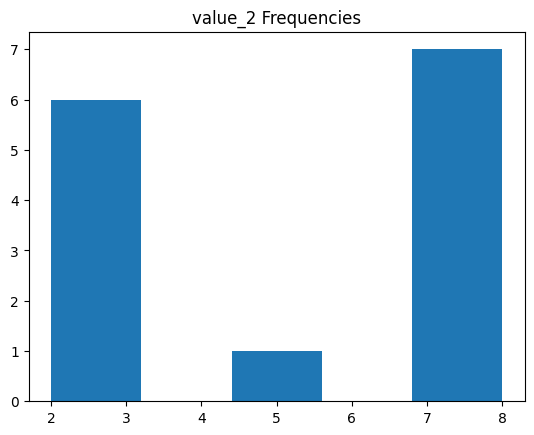

Shapiro-Wilks test: 0.004724571015685797


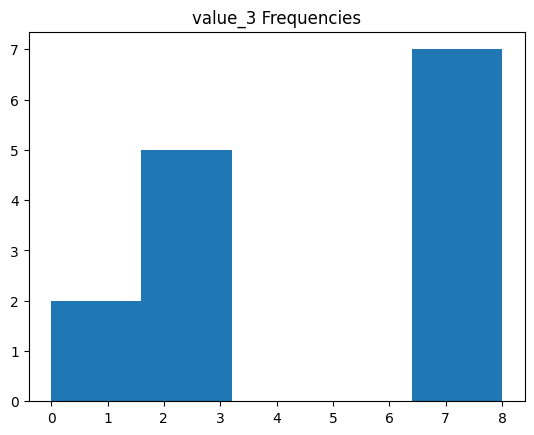

Shapiro-Wilks test: 0.00456919614225626


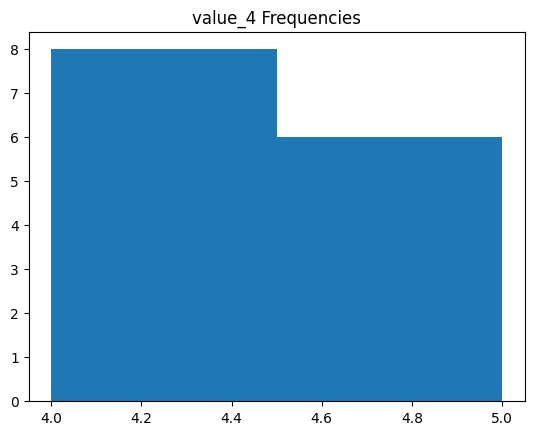

Shapiro-Wilks test: 9.202749060932547e-05


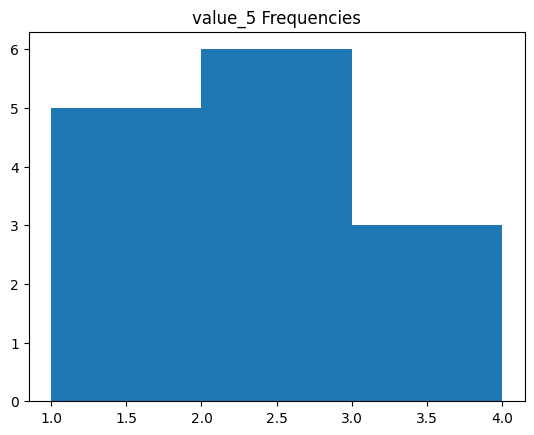

Shapiro-Wilks test: 0.002220605965703726


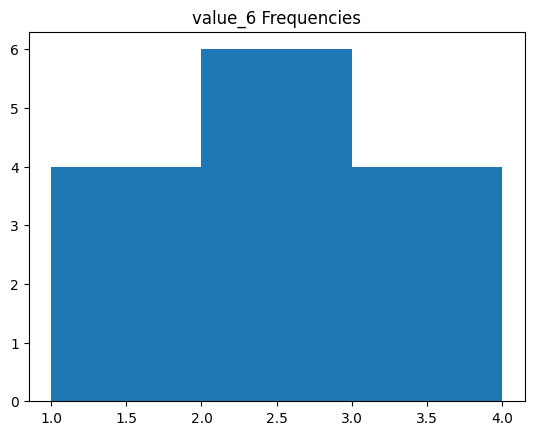

Shapiro-Wilks test: 0.003323397133499384


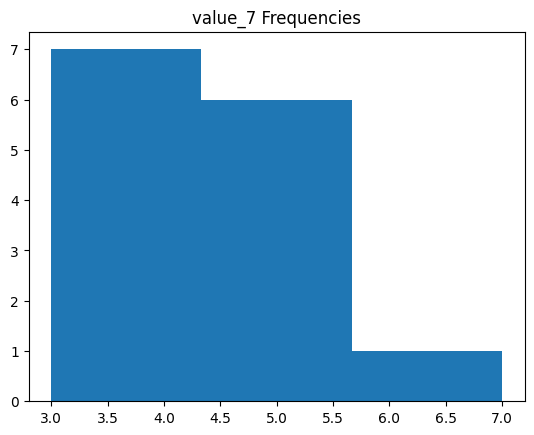

Shapiro-Wilks test: 0.0015960383461788297


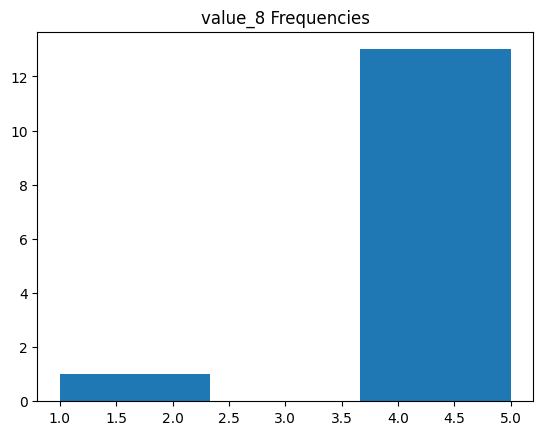

Shapiro-Wilks test: 2.6357231490692357e-06


In [5]:
value_assignment_columns = [ f'value_{i}' for i in range(9) ]

for idx, col in enumerate(value_assignment_columns):
    # get the column from the df
    column_s = data_df[col]
    if not column_s.dtype == 'int64':
        continue
    # visualize with histogram
    figure = plt.figure()
    counts, bins = np.histogram(column_s) 
    plt.hist(column_s, bins=len(set(column_s)))
    
    plt.title(f'{col} Frequencies')
    plt.show()
    # shapiro wilk test for normality
    res = shapiro(column_s)
    print(f'Shapiro-Wilks test: {res.pvalue}')

## Test Correlations

In [6]:
subplot_height = len(demo_columns)
subplot_width = 9

demo_types = ['interval', 'nominal', 'ordinal', 'ordinal', 'ordinal', 'ordinal', 'ordinal']
alpha = 0.05

corr_df = []
sig_corr_df = []
for idx, demo in enumerate(demo_columns):
    results = { 'demographic': demo }
    sig_results = { 'demographic': demo }
    for jdx, assignment in enumerate(value_assignment_columns):
        if demo_types[idx] == 'nominal':
            corr = linregress(data_df[demo], data_df[assignment])
            results[assignment] = f'{corr.slope}, p={corr.pvalue}'
            
            if corr.pvalue < alpha:
                sig_results[assignment] = f'{corr.slope}, p={corr.pvalue}'
        else:
            corr = kendalltau(data_df[demo], data_df[assignment])
            results[assignment] = f'{corr.statistic}, p={corr.pvalue}'
            if corr.pvalue < alpha:
                sig_results[assignment] = f'{corr.statistic}, p={corr.pvalue}'
    
    corr_df.append(results)
    sig_corr_df.append(sig_results)
    
corr_df = pd.DataFrame(corr_df)
sig_corr_df = pd.DataFrame(sig_corr_df)
display(corr_df)

,demographic,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8
0,age,"0.22504665034619228, p=0.3479853622974256","-0.14279694431970227, p=0.5196638662334356","0.2654659366009494, p=0.23617009174067916","-0.05309318732018988, p=0.8127166787532469","0.2645934427049934, p=0.2698427303866473","-0.27171304864640744, p=0.23327752438294214","0.21566554640687682, p=0.34281485752801244","0.2326426907609221, p=0.31917293541898395","0.3234983196103153, p=0.1702368731211341"
1,gender,"0.030716723549488064, p=0.7899807693437246","0.06143344709897612, p=0.8751302739278001","-0.08873720136518776, p=0.8607340390267391","0.5767918088737202, p=0.4046084219678675","0.06825938566552904, p=0.5643873349410942","0.6245733788395906, p=0.005851846586484315","0.20477815699658705, p=0.45885720407411434","0.05460750853242321, p=0.8555676365525562","0.13651877133105803, p=0.4921629200911529"
2,education,"0.16151457061744964, p=0.5298397985296219","0.14492753623188404, p=0.5411320386284632","0.0889108448948774, p=0.7107165572394163","0.11854779319316987, p=0.6209353118884096","-0.10425720702853739, p=0.6850850260519676","-0.24267506943642136, p=0.31993444867559284","0.0902893898143269, p=0.7105849961184058","-0.11362977583012393, p=0.6496818477114086","0.19261736493723072, p=0.44603183840846683"
3,reading,"0.12171612389003693, p=0.6607675283290312","0.0, p=1.0","-0.4773929622481257, p=0.06433384153970054","0.1256297269074015, p=0.62639648401305","-0.058925565098878974, p=0.8317488466563913","-0.051434449987363975, p=0.844842637976412","0.5103103630798288, p=0.05150833604880684","-0.16514456476895412, p=0.5402913746074198","0.0, p=1.0"
4,years_gaming,"nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan"
5,gaming_per_week,"0.41275945824459354, p=0.10837737746720458","-0.11594202898550725, p=0.6249255083254353","0.2667325346846322, p=0.26584515518265384","-0.20745863808804726, p=0.38680879884196573","0.2953954199141892, p=0.25055061131272216","-0.273009453115974, p=0.26317568906766975","0.13543408472149035, p=0.5777967879421617","0.2921908521346044, p=0.24282544043356413","0.5296977535773845, p=0.0361150453770427"
6,familiarity,"-0.0884574820723792, p=0.7286331397011504","0.2000204112874951, p=0.3952213192579913","-0.11686617901920497, p=0.6231084340652392","0.17529926852880745, p=0.46101622638538753","-0.08564858872844146, p=0.7369256096447179","0.014952043467208551, p=0.9507383823222783","0.20768679018392433, p=0.38951622822442733","-0.016002560614563885, p=0.9485777581252941","-0.23735633163877065, p=0.34373177622551154"


In [7]:
sig_corr_df

,demographic,value_5,value_8
0,age,NaN,NaN
1,gender,"0.6245733788395906, p=0.005851846586484315",NaN
2,education,NaN,NaN
3,reading,NaN,NaN
4,years_gaming,NaN,NaN
5,gaming_per_week,NaN,"0.5296977535773845, p=0.0361150453770427"
6,familiarity,NaN,NaN


Appears to be some correlation between gender and the assignment on prompt #4 (indexed at 5), and gaming_per_week with prompt #9.

## Preprocess Data

Transform data into signed distances from the expected value.

|value_index |value_real| value_label       |
|------------|----------|-------------------|
| 0          | -4       | self-direction    |
| 1          | -3       | universalism      |
| 2          | -2       | benevolence       |
| 3          | -1       | tradition         |
| 4          |  0       | security          |
| 5          |  1       | power             |
| 6          |  2       | achievement       |
| 7          |  3       | hedonism          |
| 8          |  4       | stimulation       |

In [8]:
expected_values_per_prompt = [
    5, # Expected value: power, Use Materials for Weapon Manufacturing
    6, # Expected value: achievement, Hold Parade of Victories
    7, # Expected value: hedonism, Hold a Festival for the God of Pleasure
    8, # Expected value: stimulation, Maintain an Art Museum
    3, # Expected value: security, Punish a Criminal
    0, # Expected value: benevolence, Maintain a Hospital
    1, # Expected value: universalism, Open Food Rations to Peasants
    3, # Expected value: tradition, Enforce an Hour of Prayer
    4, # Expected value: security, Reinforce the Capital City's Walls
]

VALUE_COUNT = 9

In [9]:
def computeSignedDistance(value1, value2):
    global VALUE_COUNT
    
    value2_trans1 = value2 - VALUE_COUNT
    value2_trans2 = value2 + VALUE_COUNT
    
    values_to_compare_against = [value2, value2_trans1, value2_trans2]
    
    min_dist = None
    sign = None
    for val in values_to_compare_against:
        if min_dist is None or abs(value1 - val) < min_dist:
            min_dist = abs(value1 - val)
            
            if value1 > val:
                sign = -1
            else:
                sign = 1
        
    return sign * min_dist    

In [10]:
distance_df = []
for row in data_df.iloc:
    new_row = {}
    for idx, col in enumerate(value_assignment_columns):    
        new_row[col] = computeSignedDistance(expected_values_per_prompt[idx], row[col])
        
    distance_df.append(new_row)
    
distance_df = pd.DataFrame(distance_df)
display(distance_df)

,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8
0,0,-1,0,1,2,1,0,4,0
1,0,-1,0,0,1,1,0,0,0
2,0,1,-4,0,2,2,1,2,0
3,-1,-1,0,0,1,2,1,0,0
4,0,-1,0,0,2,1,3,2,0
5,0,0,-4,0,1,2,1,2,0
6,-1,0,1,0,1,4,0,0,0
7,0,1,-4,4,1,1,0,2,0
8,-1,4,4,-1,2,4,3,0,-3
9,-1,-1,0,4,1,2,1,0,0


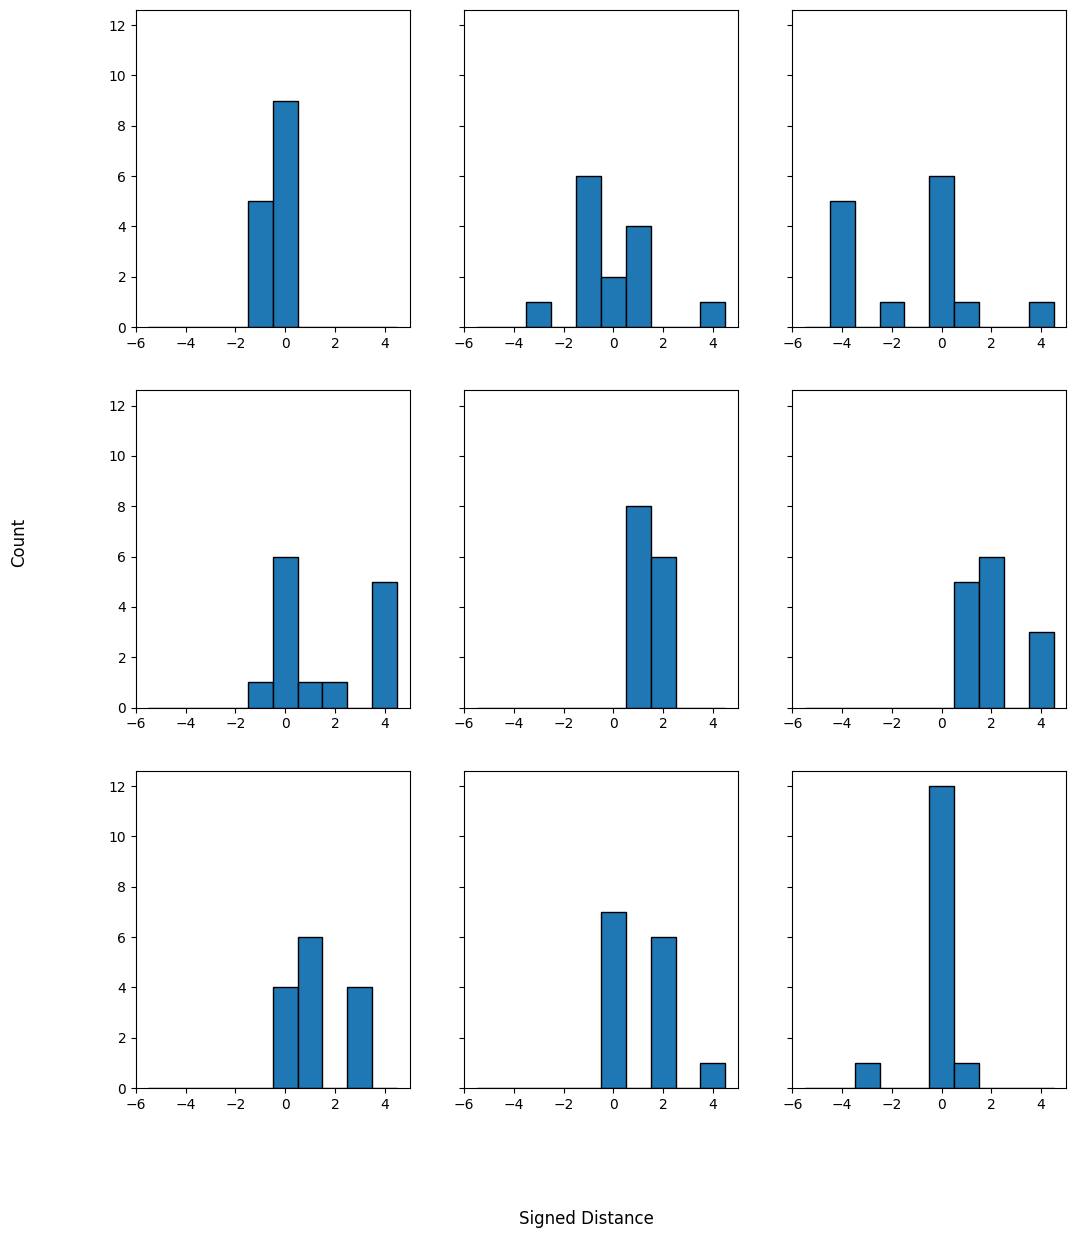

In [11]:
bins = list(range(-5, 6))
fig, axs = plt.subplots(3, 3, sharex=False, sharey=True, figsize=(12, 14))
plots = axs.reshape(9,)
for value_index, row in enumerate(distance_df.T.iloc):
    plot = plots[value_index]
    plot.hist(row, bins=bins, align='left', edgecolor='black')
    
fig.supxlabel('Signed Distance')
fig.supylabel('Count')
plt.show()

In [23]:
shapiro_tests = []
alpha = 0.05
for value_index, row in enumerate(distance_df.T.iloc):
    test_res = shapiro(row)
    shapiro_tests.append({
        'mean': statistics.mean(row),
        'median': statistics.median(row),
        'iqr': iqr(row),
        'std': row.std(),
        'shapiro-statistic': test_res.statistic,
        'shapiro-pvalue': test_res.pvalue,
        'shapiro-is_sig': test_res.pvalue < alpha
    })
    
shapiro_tests = pd.DataFrame(shapiro_tests)
display(shapiro_tests)

,mean,median,iqr,std,shapiro-statistic,shapiro-pvalue,shapiro-is_sig
0,-0.357143,0.0,1.00,0.497245,0.615978,0.000057,True
1,-0.071429,-0.5,2.00,1.639150,0.877483,0.053518,False
2,-1.214286,0.0,4.00,2.486226,0.838038,0.015342,True
3,1.571429,0.5,4.00,1.988981,0.777445,0.002661,True
4,1.428571,1.0,1.00,0.513553,0.638846,0.000092,True
5,2.071429,2.0,1.00,1.141139,0.770772,0.002221,True
6,1.285714,1.0,2.25,1.204388,0.785524,0.003323,True
7,1.142857,1.0,2.00,1.292412,0.758385,0.001596,True
8,-0.142857,0.0,0.00,0.864438,0.453991,0.000003,True
